In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd 

import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import Angle, EarthLocation, AltAz, SkyCoord
from astropy.time import Time
from astropy.visualization import hist
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter

In [2]:
MMT_LOCATION = EarthLocation.from_geodetic("-110:53:04.4", "31:41:19.6", 2600 * u.m)
obstime = Time("2021-08-21T06:00:00", format='isot')

# don't strictly need time or location for our purposes, but astropy wants them for defining the alt/az frame
aa_frame = AltAz(obstime=obstime, location=MMT_LOCATION)

def tpoint(
        coo, 
        ia=0., 
        ie=0., 
        an=0., 
        aw=0., 
        ca=0., 
        npae=0., 
        tf=0., 
        tx=0.
    ):
    """
    Apply 8-term alt-az tpoint model to set of raw alt-az coordinates and return corrected coordinates
    """
    da = -1 * ia
    da -= an * np.sin(coo.az) * np.tan(coo.alt)
    da -= aw * np.cos(coo.az) * np.tan(coo.alt)
    da -= ca / np.cos(coo.alt)
    da -= npae * np.tan(coo.alt)

    de = ie
    de -= an * np.cos(coo.az)
    de += aw * np.sin(coo.az)
    de -= tf * np.cos(coo.alt)
    de -= tx / np.tan(coo.alt)

    new_az = coo.az + da * u.arcsec
    new_alt = coo.alt + de * u.arcsec

    new_coo = SkyCoord(new_az, new_alt, frame=aa_frame)
    return new_coo

def skyrms(coo_ref, coo_meas):
    """
    Calculate sky RMS of the offsets between reference and measured coordinates in the same way as tpoint.
    Return the result in arcseconds.
    """
    sep = coo_ref.separation(coo_meas)
    rms = np.sqrt((sep ** 2).mean()).to(u.arcsec)
    return rms

def psd(coo_ref, coo_meas, nterms=8):
    """
    Calculate the population standard deviation, PSD, the way tpoint does. Returh the result in arcseconds. 
    """
    rms = skyrms(coo_ref, coo_meas)
    sd = np.sqrt(rms**2 * len(coo_meas) / (len(coo_meas) - nterms))
    return sd

def pointing_histogram(coo_ref, coo_meas):
    seps = coo_ref.separation(coo_meas)
    with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
        fig, ax = plt.subplots(figsize=[9, 6])
        bins = np.arange(0, 20)/4  # 0.25" bins
        ax.hist(seps.to(u.arcsec).value, bins=bins, alpha=0.6)
        ax.set_ylabel("N")
        ax.set_xlabel("Pointing Error (arcsec)")
        med = np.median(seps.to(u.arcsec))
        rms = skyrms(coo_obs, t_coo)
        skypsd = psd(coo_obs, t_coo)
        ax.vlines(x=med.value, ymin=0, ymax=1, transform=ax.get_xaxis_transform(), color='gray', alpha=0.5, ls='-', label=f"Median: {med.value:.2f}\"")
        ax.vlines(x=rms.value, ymin=0, ymax=1, transform=ax.get_xaxis_transform(), color='gray', alpha=0.5, ls='--', label=f"RMS: {rms.value:.2f}\"")
        ax.vlines(x=skypsd.value, ymin=0, ymax=1, transform=ax.get_xaxis_transform(), color='gray', alpha=0.5, ls=':', label=f"PSD: {skypsd.value:.2f}\"")
        ax.legend()
        ax.set_xlim(0.0, 5.0)
    return fig

def pointing_residuals(coo_ref, coo_meas):
    az_res, el_res = coo_meas.spherical_offsets_to(coo_ref)
    with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
        fig, ax = plt.subplots(figsize=[6, 6])
        ax.set_aspect('equal')
        ax.scatter(az_res.to(u.arcsec), el_res.to(u.arcsec))
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])
        ax.set_xlabel("$\Delta$A (arcsec)")
        ax.set_ylabel("$\Delta$E (arcsec)")
        ax.set_title("Azimuth-Elevation Residuals")
        c1 = matplotlib.patches.Circle((0, 0), 1, ec='black', lw=4, fill=False, alpha=0.4, label="1\"")
        ax.add_patch(c1)
        ax.legend()
    return fig

def pointing_sky(coo_ref, coo_meas):
    az_res, el_res = coo_meas.spherical_offsets_to(coo_ref)
    with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
        x = coo_ref.az
        y = 90 * u.degree - coo_ref.alt  # use zenith angle here as a trick
        uu = (az_res).to(u.arcsec).value
        vv = (-1 * el_res).to(u.arcsec).value
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=[8, 8])
        qq = ax.quiver(
            x.to(u.radian).value, 
            y.value, 
            uu, 
            vv, 
            np.sqrt(uu**2 + vv**2),
            scale_units='y', 
            angles='xy', 
            pivot='tip', 
            color='red'
        )
        #qk = ax.quiverkey(qq, 0.95, 0.95, 1, "1\"", labelpos='W', coordinates='axes', angle=0.0)
        ax.set_rmax(90)
        ticks = [0, 15, 30, 45, 60, 75, 90]
        ax.set_rticks(ticks)
        ax.set_rlim(0, 90)
        ax.set_yticklabels([
            "$90^{\circ}$",
            "$75^{\circ}$",
            "$60^{\circ}$",
            "$45^{\circ}$",
            "$30^{\circ}$",
            "$15^{\circ}$",
            "El = $0^{\circ}$",
        ])
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.scatter(x.to(u.radian).value, y.value)
    cbar = plt.colorbar(qq, shrink=0.7)
    cbar.set_label("arcsec")
    plt.tight_layout()
    return fig

def pointing_azel_resid(coo_ref, coo_meas):
    az_res, el_res = coo_meas.spherical_offsets_to(coo_ref)
    az_res = az_res.to(u.arcsec)
    el_res = el_res.to(u.arcsec)
    az = coo_ref.az
    el = coo_ref.alt
    z = 90 * u.degree - el
    azel_max = np.max([5, np.abs(az_res).max().to(u.arcsec).value, np.abs(el_res).max().to(u.arcsec).value])
    with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
        fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='row')
        
        axs[0, 0].set_ylim(-azel_max, azel_max)
        axs[1, 0].set_xlim(0, 360)
        axs[1, 0].set_ylim(-azel_max, azel_max)
        axs[1, 1].set_xlim(0, 90)
        
        axs[0, 0].scatter(az, az_res)
        axs[1, 0].scatter(az, el_res)
        
        axs[0, 1].scatter(el, az_res)
        axs[1, 1].scatter(el, el_res)
        
        axs[0, 0].set_ylabel("$\Delta A$ (arcsec)")
        axs[1, 0].set_ylabel("$\Delta E$ (arcsec)")
        axs[1, 0].set_xlabel("Azimuth")
        axs[1, 0].set_xticks([0, 90, 180, 270, 360])
        axs[1, 0].set_xticklabels(["N", "E", "S", "W", "N"])
        axs[1, 1].set_xlabel("Elevation")
        axs[1, 1].set_xticks([0, 15, 30, 45, 60, 75, 90])
        axs[1, 1].set_xticklabels([f"{i}" + "$^{\circ}$" for i in [0, 15, 30, 45, 60, 75, 90]])
    
    plt.tight_layout()
    return fig

In [3]:
datafile = "point_tweak.dat"
t = ascii.read(datafile, data_start=20, format='no_header', guess=False, fast_reader=False)
az_obs = Angle(t['col1'], unit=u.degree).wrap_at(360 * u.deg)
el_obs = Angle(t['col2'], unit=u.degree).wrap_at(360 * u.deg)
az_raw = Angle(t['col3'], unit=u.degree).wrap_at(360 * u.deg)
el_raw = Angle(t['col4'], unit=u.degree).wrap_at(360 * u.deg)
coo_obs = SkyCoord(az_obs, el_obs, frame=aa_frame)
coo_raw = SkyCoord(az_raw, el_raw, frame=aa_frame)

In [4]:
t_coo = tpoint(coo_raw, 1212.01, -2.99, 2.51, -10.34, -10.10, 0.0, 21.41, -2.71)
seps = coo_obs.separation(t_coo)
np.median(seps.to(u.arcsec))

<Angle 0.73505297 arcsec>

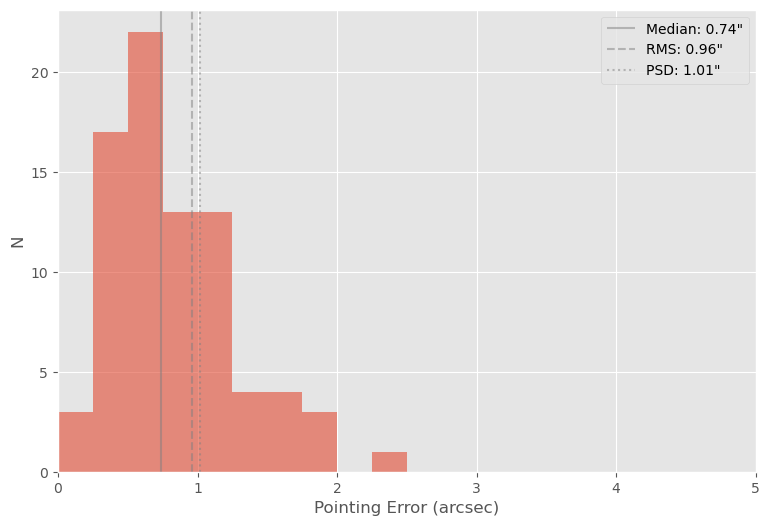

In [5]:
f = pointing_histogram(coo_obs, t_coo)

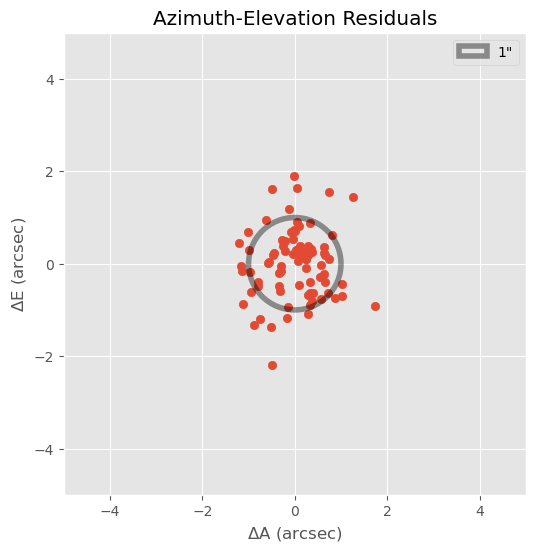

In [6]:
f = pointing_residuals(coo_obs, t_coo)

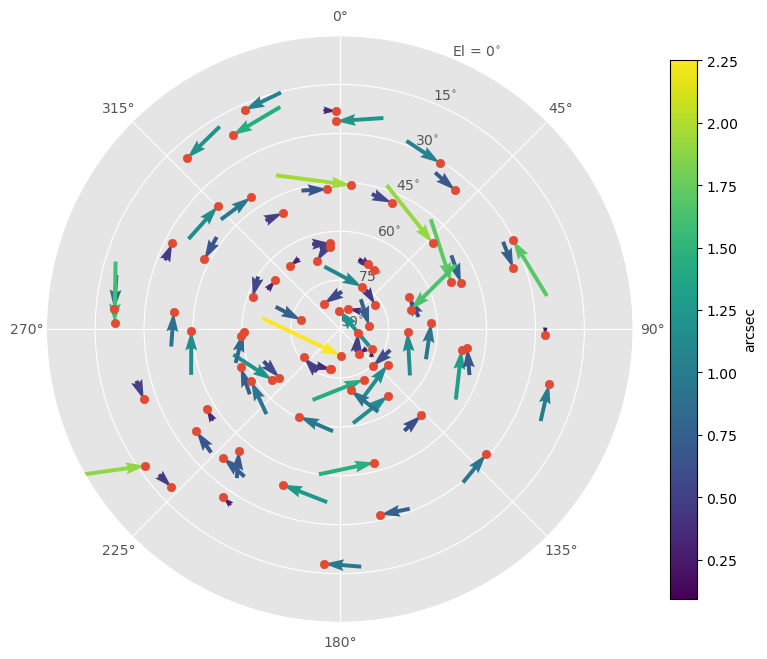

In [7]:
f = pointing_sky(coo_obs, t_coo)

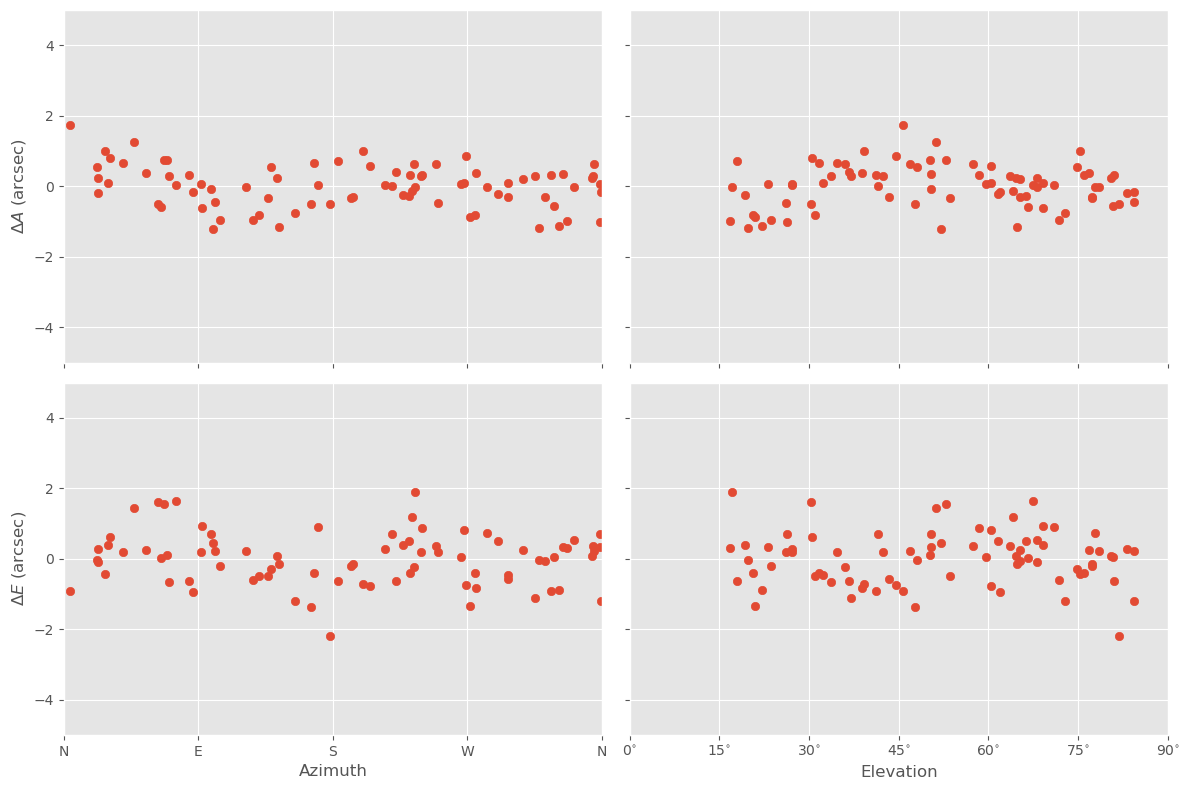

In [8]:
f = pointing_azel_resid(coo_obs, t_coo)

In [9]:
import pymc3 as pm
import arviz
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


In [10]:
data = pd.DataFrame(columns=['az', 'el', 'az_raw', 'el_raw'])
data['az'] = az_obs.value
data['el'] = el_obs.value
data['az_raw'] = az_raw.value
data['el_raw'] = el_raw.value
data

,az,el,az_raw,el_raw
0,192.386028,77.346841,192.722109,77.347548
1,193.388517,77.285063,193.724448,77.285715
2,183.793877,17.903059,184.128297,17.906492
3,200.154632,39.171912,200.489313,39.174967
4,204.724949,60.407578,205.059677,60.409279
...,...,...,...,...
75,138.458109,74.792431,138.793142,74.796064
76,142.934568,80.414701,143.270090,80.417527
77,170.022957,70.943687,170.359532,70.945741
78,177.928058,81.862398,178.266096,81.863964


In [50]:
tpoint_model = pm.Model()
deg2rad = np.pi / 180
with tpoint_model:
    az = pm.Data('az', coo_obs.az)
    el = pm.Data('el', coo_obs.alt)
    az_raw = pm.Data('az_raw', coo_raw.az)
    el_raw = pm.Data('el_raw', coo_raw.alt)
    """
    ia = pm.Uniform('ia', 1000., 1400.)
    ie = pm.Uniform('ie', -50., 50.)
    an = pm.Uniform('an', -20., 20.)
    aw = pm.Uniform('aw', -20., 20.)
    ca = pm.Uniform('ca', -30., 30.)
    npae = pm.Uniform('npae', -30., 30.)
    tf = pm.Uniform('tf', -50., 50.)
    tx = pm.Uniform('tx', -10., 10.)
    """

    ia = pm.Normal('ia', 1200., 100)
    ie = pm.Normal('ie', 0., 50.)
    an = pm.Normal('an', 0., 20.)
    aw = pm.Normal('aw', 0., 20.)
    ca = pm.Normal('ca', 0., 30.)
    npae = pm.Normal('npae', 0., 30.)
    tf = pm.Normal('tf', 0., 50.)
    tx = pm.Normal('tx', 0., 10.)
    
    daz = -ia - an * pm.math.sin(deg2rad * az) * pm.math.tan(deg2rad * el) - \
        aw * pm.math.cos(deg2rad * az) * pm.math.tan(deg2rad * el) - \
            ca / pm.math.cos(deg2rad * el) - npae * pm.math.tan(deg2rad * el)
    dalt = ie - an * pm.math.cos(deg2rad * az) + aw * pm.math.sin(deg2rad * az) - tf * pm.math.cos(deg2rad * el) - tx / pm.math.tan(deg2rad * el)
    """
    daz = -ia
    dalt = ie
    """
    separations = (az - (az_raw + daz/3600.)) ** 2 + (el - (el_raw + dalt/3600.)) ** 2
    
    _ = pm.Normal('likelihood', mu = 0. * separations, sigma=pm.HalfNormal('sigma', sigma=1/3600), observed=separations)
    
    idata = pm.sample(
        20000,
        tune=4000,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=8675309
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tx, tf, npae, ca, aw, an, ie, ia]


Sampling 4 chains for 4_000 tune and 20_000 draw iterations (16_000 + 80_000 draws total) took 663 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'ia'}>,
        <AxesSubplot:title={'center':'ie'}>,
        <AxesSubplot:title={'center':'an'}>],
       [<AxesSubplot:title={'center':'aw'}>,
        <AxesSubplot:title={'center':'ca'}>,
        <AxesSubplot:title={'center':'npae'}>],
       [<AxesSubplot:title={'center':'tf'}>,
        <AxesSubplot:title={'center':'tx'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

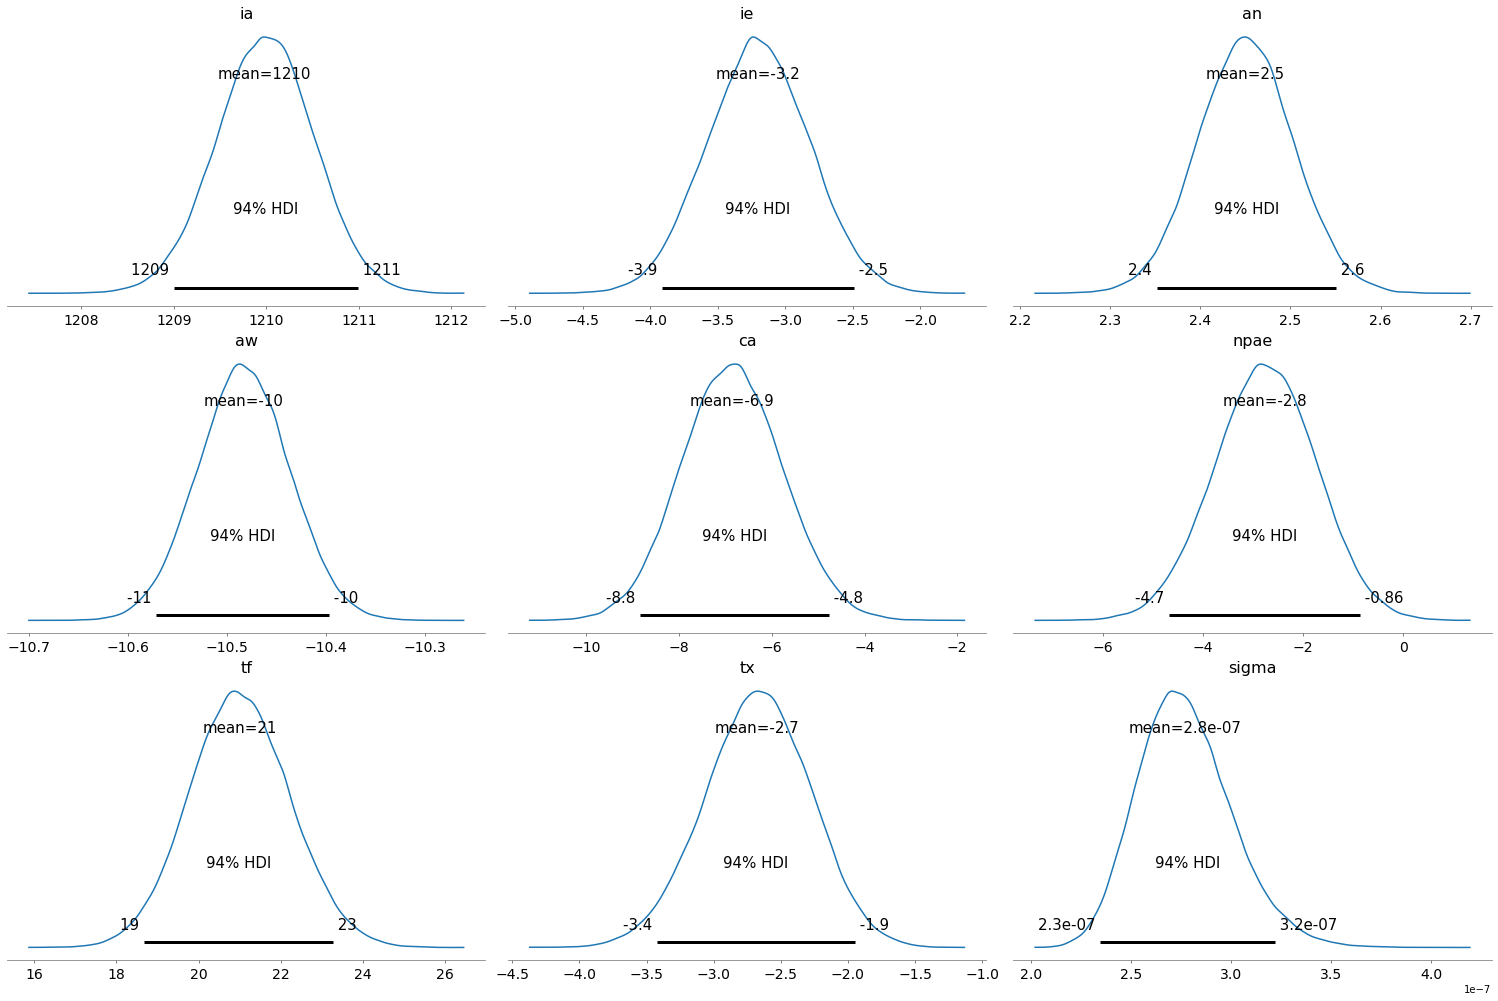

In [53]:
arviz.plot_posterior(idata)

In [52]:
arviz.summary(idata, round_to=8)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ia,1.209984e+03,5.290288e-01,1.208999e+03,1.210988e+03,0.002817,0.001992,35263.534280,44571.257688,1.000056
ie,-3.201839e+00,3.808772e-01,-3.915072e+00,-2.486733e+00,0.001803,0.001275,44645.582357,51955.777103,1.000011
an,2.450094e+00,5.307646e-02,2.351329e+00,2.550307e+00,0.000221,0.000156,57634.718782,53416.843606,0.999992
aw,-1.048328e+01,4.652290e-02,-1.057157e+01,-1.039668e+01,0.000195,0.000138,56916.691558,52937.751380,1.000142
ca,-6.851765e+00,1.087897e+00,-8.848838e+00,-4.767666e+00,0.005891,0.004166,34108.399862,41269.329947,1.000034
npae,-2.765073e+00,1.020021e+00,-4.689737e+00,-8.643204e-01,0.005491,0.003897,34513.124311,41748.627934,1.000033
tf,2.100982e+01,1.221792e+00,1.867259e+01,2.326799e+01,0.006283,0.004451,37860.556196,41539.831176,1.000023
tx,-2.676812e+00,3.935919e-01,-3.423672e+00,-1.944444e+00,0.001897,0.001349,43143.058010,48124.983423,1.000022
sigma,2.800000e-07,2.000000e-08,2.300000e-07,3.200000e-07,0.000000,0.000000,56524.851461,51872.411683,1.000126


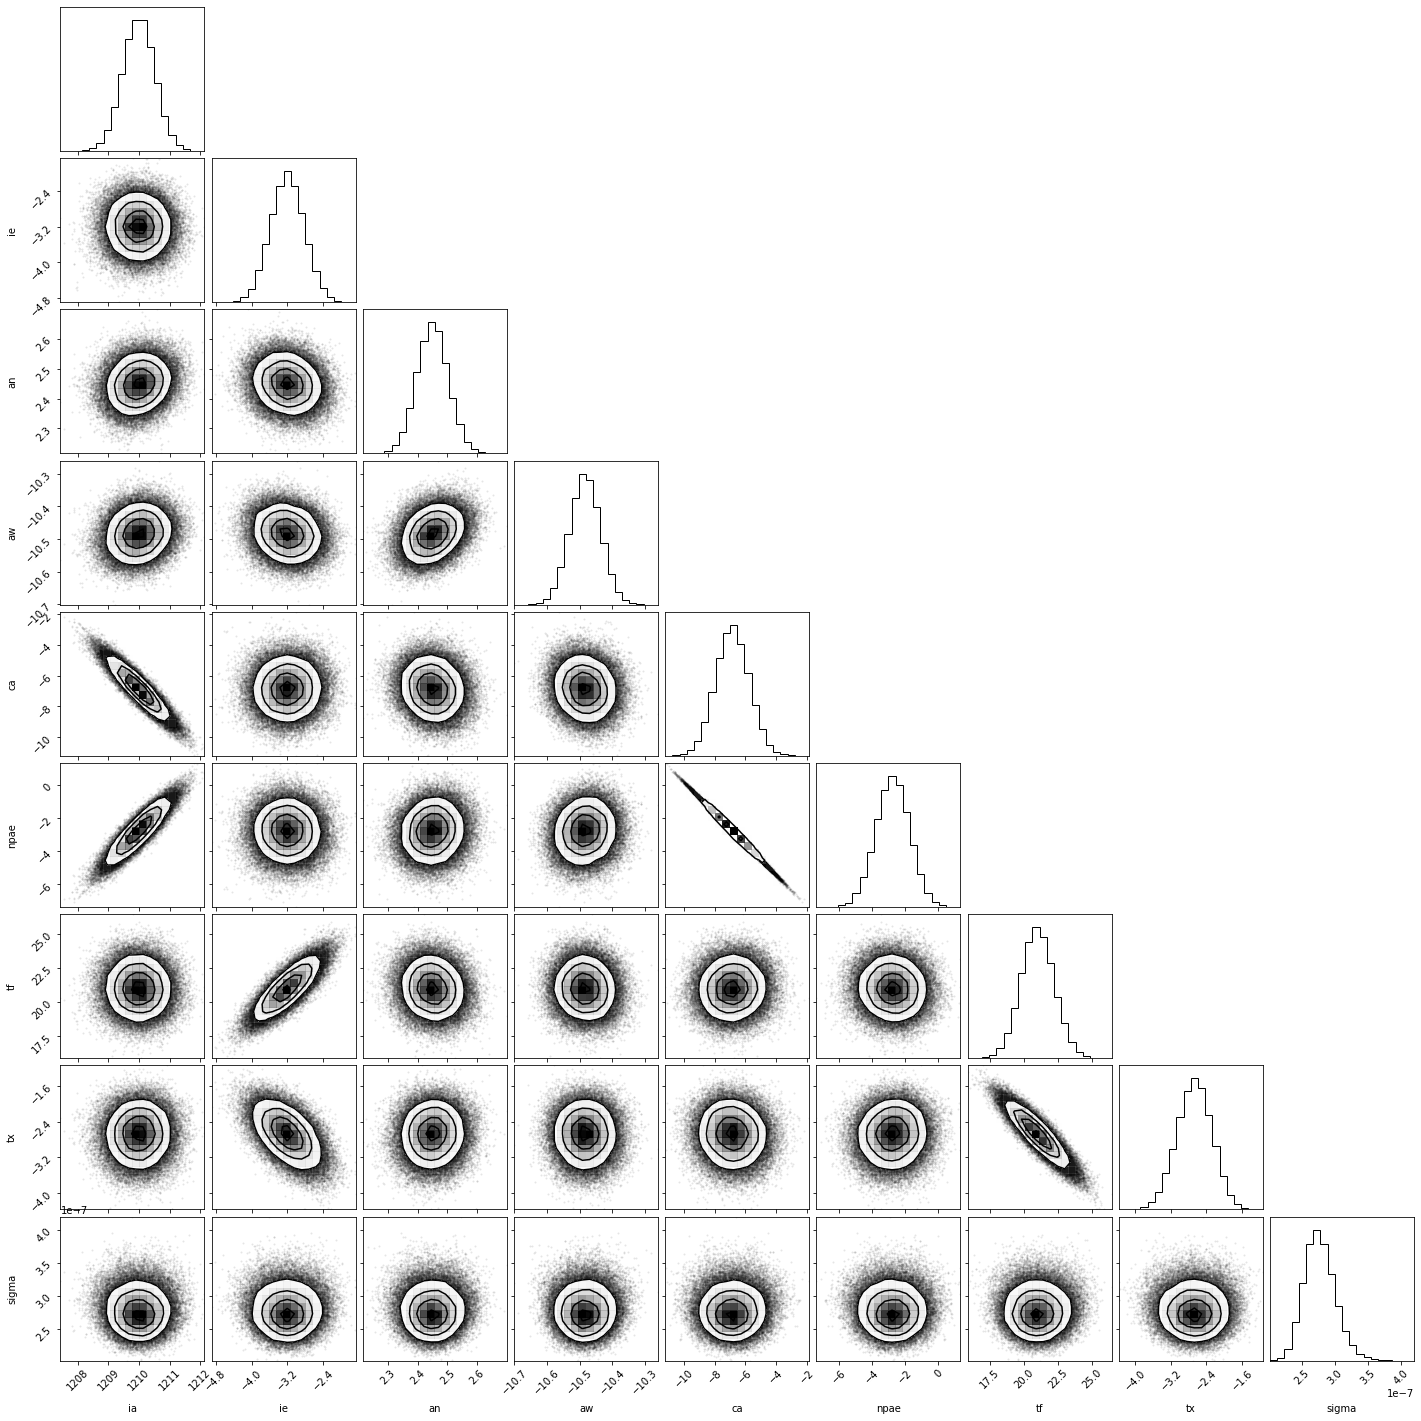

In [56]:
import corner
_ = corner.corner(idata)